# Shortest Path between Two Intersections in California Road Network

The California road network consits of intersections -point locations on the California map having (x,y) coordinates- and roads each of which conects a pair of intersections. In this notebook, graph network is used to calculate and visualize the sortest path between two points.

In [1]:
import sqlite3 as db
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from networkx import Graph, shortest_path, shortest_path_length

In [2]:
def node_coords(sx, sy):
    """
    returns the (x,y) coordinates as a list of tuples
    """
    return [(x,y) for x,y in zip(sx,sy)]

def edge_coords(axy, bxy):
    return [[a,b] for a,b in zip(axy,bxy)]

def plot_roads(E, ax=None, color='b'):
    """
    plots the network of roads
    """
    if ax is None: ax=plt.gca()
    if type(E) is pd.core.frame.DataFrame:
        A = node_coords(E["AX"],E["AY"])
        B = node_coords(E["BX"],E["BY"])
        E = edge_coords(A,B)
    
    ec = LineCollection(E,color = [color] * len(E))    
    ax.add_collection(ec)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.autoscale()

def plot_point(x,y,markerstyle):
    plt.plot(x,y,markerstyle,markersize=10)
    
def get_intersection_coords(i, df):
    return df["X"].iloc[i], df["Y"].iloc[i]

In [3]:
def path_to_coords(path, df):
    path_coords=[]
    for i,j in zip(path[:-1],path[1:]):
        path_coords.append([tuple(df.loc[df['ID']==i,['X','Y']].values[0]), tuple(df.loc[df['ID']==j,['X','Y']].values[0])])
    return path_coords

def get_shortest_path(network, df, origin, dest):
    """
    visualizes and returns the sortest path between two intersections
    """
    path=shortest_path(network,source=origin,target=dest,weight='w')
    distance=shortest_path_length(network,source=origin,target=dest,weight='w')
    path_coords=path_to_coords(path, df)
    f,ax=plt.subplots(figsize=(10,10))
    plot_roads(df_roads,ax=ax)
    plot_roads(path_coords,ax=ax,color='r')
    plot_point(*tuple(df.loc[df['ID']==origin,['X','Y']].values[0]), 'ko')
    plot_point(*tuple(df.loc[df['ID']==dest,['X','Y']].values[0]), 'k*')
    return distance

In [4]:
conn=db.connect('./Data/network.db')

In [5]:
for match in conn.execute('select * from sqlite_master'):
    print(match)

('table', 'Intersections', 'Intersections', 2, 'CREATE TABLE "Intersections" (\n"ID" INTEGER,\n  "X" REAL,\n  "Y" REAL\n)')
('table', 'Roads', 'Roads', 144, 'CREATE TABLE "Roads" (\n"ID" INTEGER,\n  "AID" INTEGER,\n  "BID" INTEGER\n)')


The databse has two tables: `Intersections` and `Roads`

**Intersections** are nodes with (x,y) coordinates<br>
**Rodes** are edges with segment bewteen two intersections 

In [6]:
df_intersections=pd.read_sql_query('select * from Intersections', conn)
df_intersections.head()

,ID,X,Y
0,0,-121.904167,41.974556
1,1,-121.902153,41.974766
2,2,-121.896790,41.988075
3,3,-121.889603,41.998032
4,4,-121.886681,42.008739


Each intersection is a row in the database. It has a unique integer identifier (the "ID" columns) and (x,y)-coordinates.

In [7]:
pd.read_sql_query('select * from Roads limit 5', conn)

,ID,AID,BID
0,0,0,1
1,1,0,6
2,2,1,2
3,3,2,3
4,4,3,4


Each road (segment) is a row of the table with a unique identifier ID (the "ID" column). It connects two intersections (A and B). The ID of the points are "AID" and "BID".

In [8]:
# joining the two tables by adding the coordinates of A and B to road table:
query='''
select Roads.ID as E, 
A_node.ID as A, A_node.X as AX, A_node.Y as AY, 
B_node.ID as B, B_node.X as BX, B_node.Y as BY
from Roads
inner join
Intersections as A_node
on Roads.AID=A_node.ID
inner join 
Intersections as B_node
on Roads.BID=B_node.ID
'''
df_roads=pd.read_sql_query(query,conn)
conn.close()
df_roads.head(10)

,E,A,AX,AY,B,BX,BY
0,0,0,-121.904167,41.974556,1,-121.902153,41.974766
1,1,0,-121.904167,41.974556,6,-121.910088,41.973942
2,2,1,-121.902153,41.974766,2,-121.896790,41.988075
3,3,2,-121.896790,41.988075,3,-121.889603,41.998032
4,4,3,-121.889603,41.998032,4,-121.886681,42.008739
5,5,5,-121.915062,41.970314,6,-121.910088,41.973942
6,6,5,-121.915062,41.970314,7,-121.916199,41.969482
7,7,5,-121.915062,41.970314,8,-121.903198,41.968456
8,8,7,-121.916199,41.969482,265,-121.918793,41.967587
9,9,8,-121.903198,41.968456,298,-121.897881,41.967625


# Step 1) Calculating road segment lengths

To calculate the shortest path between any two intersections, we ned to know the length of each road segment.

In [9]:
df_roads["L"]=df_roads.apply(lambda x:((x['AX']-x['BX'])**2+(x['AY']-x['BY'])**2)**0.5, axis=1)
df_roads.head()

,E,A,AX,AY,B,BX,BY,L
0,0,0,-121.904167,41.974556,1,-121.902153,41.974766,0.002025
1,1,0,-121.904167,41.974556,6,-121.910088,41.973942,0.005953
2,2,1,-121.902153,41.974766,2,-121.896790,41.988075,0.014349
3,3,2,-121.896790,41.988075,3,-121.889603,41.998032,0.012280
4,4,3,-121.889603,41.998032,4,-121.886681,42.008739,0.011099


# Step 2) Creating a list of edges

In [10]:
edge_list= [(i,j, {'w':k}) for i,j,k in zip(df_roads['A'],df_roads['B'],df_roads['L'])]
edge_list[:5]

[(0, 1, {'w': 0.002024918763790657}),
 (0, 6, {'w': 0.005952750372727481}),
 (1, 2, {'w': 0.01434891110851992}),
 (2, 3, {'w': 0.012279854152221105}),
 (3, 4, {'w': 0.011098555446539574})]

# Step 3) Creating graph object

In [11]:
G=Graph()
G.add_nodes_from(df_intersections["ID"])
G.add_edges_from(edge_list)

print(f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges!")

The graph has 21048 nodes and 21693 edges!


The shortest distance is 8.75


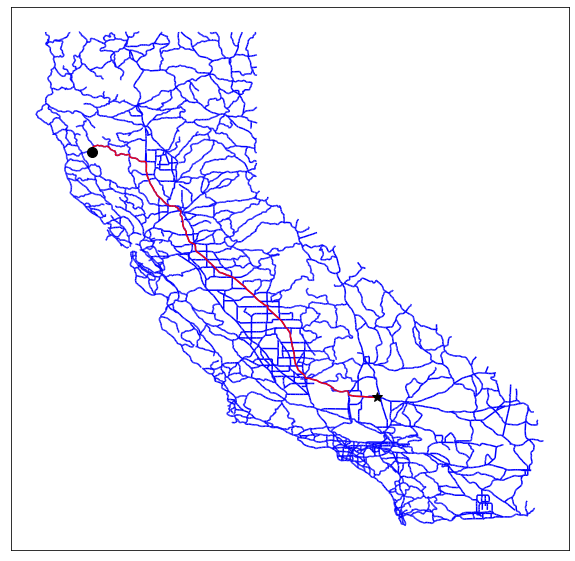

In [12]:
start_id=4000
stop_id=15000
print(f"The shortest distance is {get_shortest_path(G,df_intersections,start_id,stop_id):.2f}")

The shortest distance is 12.39


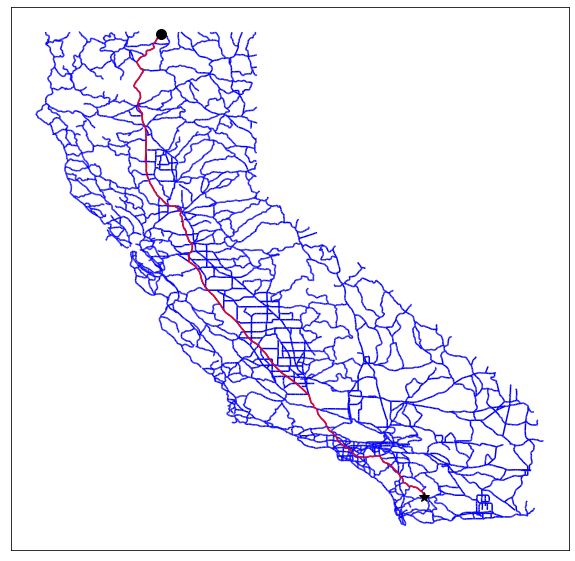

In [13]:
start_id=0
stop_id=20000
print(f"The shortest distance is {get_shortest_path(G,df_intersections,start_id,stop_id):.2f}")